# Workspace set-up

In [1]:
import numpy as np
from scipy.linalg import svd
from scipy.optimize import least_squares
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

from cvxpy import Variable, Minimize, Problem
from cvxpy import norm as cvxnorm
from cvxpy import multiply, SCS
from cvxpy import vec as cvxvec

from scipy.sparse.linalg import svds

from mc_util import *
from mc_solve import *

In [2]:
np.random.seed(seed=3)

# Introduction

## Background

### Notation

In this tutorial, we denote a fixed matrix $M \in \mathbb{R}^{m \times n}$ where $m$ and $n$ are positive integers. Elements of $M$ will be denoted using subscript notation, so that the element in the $i$th row and $j$th column of $M$ is denoted by $M_{ij}$ for any $(i,j) \in [m] \times [n]$ where $[m] := \{1, 2, \ldots, m\}$. We will say that a matrix $X$ is a **random matrix** if each of its entries $X_{ij}$ come from a distribution $\mathcal{D}_{ij}$ (and write $X_{ij} \sim \mathcal{D}_{ij}$). Typically, one has $\mathcal{D}_{ij} = \mathcal{D}$ for some distribution $\mathcal{D}$ and all $i,j$ (*e.g.*, the standard normal distribution $\mathcal{D} \sim \mathcal{N}(0,1)$). Moreover, for the purpose of this tutorial, we will assume that $X_{ij} \overset{iid}{\sim} \mathcal{D}$ are **independent and identically distributed** (iid) samples from the distribution $\mathcal{D}$. In general, this may be much too strict an assumption; we will explore this in some detail below. 

### Tools from probability

For $\Omega \subseteq [m] \times [n]$, a subset of indices of a matrix, the **subsampled matrix** $M_\Omega$ has entries given by 
$$
M_\Omega := \begin{cases}
M_{ij} & (i,j) \in \Omega\\
0 & (i,j) \not\in \Omega
\end{cases}
$$
Entries of a fixed matrix $M$ are observed **uniform at random** with probability $p \in (0,1)$ if, for all $(i,j) \in [m]\times[n]$, the probability that $(i,j) \in \Omega$ is equal to $p$. 

We denote by $\mathbb E$ the expectation operator for a random variable; and $\mathrm{Var}$ the variance. Let $\hat \theta$ be an estimator for a random variable $\theta$. The **bias** of the estimator $\hat \theta$ is given by $B(\hat\theta) = \mathbb E [\hat \theta] - \theta$. An estimator for which $B \equiv 0$ is said to be an **unbiased estimator**.

# Matrix completion theory

## First pass at the problem

Let $M \in \mathbb{R}^{n\times n}$ be a fixed real-valued square matrix and let $\Omega \subseteq [n] \times [n]$ be a set of indices of the matrix corresponding to the set of observed entries. 

A first pass at the **matrix completion problem** is as follows:

> Given only $\Omega\subseteq [n]\times[n]$ and corresponding entries $\{M_{ij}\}_{(i,j) \in \Omega}$, recover the full matrix $M$.

## Motivation for solving this problem

A good question to ask in an applied math workshop: besides mathematical interest, why do we care about solving this problem? Below are a few examples, with asterisks beside ones that make guest appearances in this tutorial.

* The Netflix challenge \*
* Subsurface reconstruction in geophysics and petrology
* Bathymetry interpolation in meteorology, hydrology and geophysics \*
* *Terroir* characterization
* Online shopping patterns
* Music listening & book reading preferences \*
* Inference on certain graph structures \*

## Making the problem feasible

### "Entry determinism"

As it is posed above, this problem is unfeasible. **Why!?** In general, one element in a matrix **does not determine** the other elements in a matrix! In order to make the matrix completion problem tractable, we have to impose some constraints on our matrix — these constraints will ensure that [in some sense], the entries we have observed will determine the values that we have not observed.

**So what should this constraint be?** Just as when working with vectors, there could be several ways to constrain a given vector; however, a common theme that runs between all of the examples listed above is that the associated matrices have some **intrinsic low-dimensional structure**. <div class='alert alert-block alert-info'>For this reason, the relevant kind of structure with which we will imbue $M$ is a **constraint on the rank of $M$**. In particular, for a positive integer $r \ll n$, we will assume that $\mathrm{rank}(M) = r$. </div>

With $M$ being *of low rank*, it follows that we can represent $M$ by 
$$
M = WH^*, \qquad W, H \in \mathbb{R}^{n\times r}
$$
which is seen clearly from the SVD-like representation of $M$
$$
M = U \Sigma V^* \qquad U, V \in \mathbb{R}^{n\times r}, \Sigma \in \mathbb{R}^{r\times r}
$$
where $\Sigma$ is a diagonal matrix whose elements $\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_r$ are the **non-zero singular values** of $M$; and $U$ and $V$ are unitary matrices (*i.e.*, $UU^* \equiv U^* U \equiv VV^* \equiv V^* V \equiv 1$).

#### Example: Singular Value Decomposition

In [3]:
# settings
n, r = (50, 5)
W = np.random.randn(n,r)
H = np.random.randn(n,r)
M = W @ H.T

# svd
U, Sigma, Vtr = svd(M)

print(U.shape)
print(Sigma.size)
print(Vtr.shape)

(50, 50)
50
(50, 50)


Are we really getting 50 singular values for `M`?

In [4]:
print(Sigma[:2*r].round(3))

[64.538 57.021 51.371 43.676 36.003  0.     0.     0.     0.     0.   ]


Yes, but `n-r` of them are equal to $0$ (up to numerical precision). This means we can get a more efficient representation of `M` in SVD format. We'll take only the first `r` columns of `U`; the first `r` rows of `Vtr`; and only the positive singular values of `Sigma`.

In [5]:
U_r = U[:, :r]
Vtr_r = Vtr[:r, :]
Sigma_r = Sigma[:r]

In [6]:
M2 = U_r @ np.diag(Sigma_r) @ Vtr_r

In [7]:
print('root mean-squared error = {:5.3g}'.format(rmse(M2, M)))

root mean-squared error = 1.49e-15


**Note:** `scipy.linalg.svd` computes the entire SVD of the matrix — if we know that a matrix is of low rank, then we can use the more efficient `randomized_svd` from `sklearn.decomposition.truncated_svd`, which returns only the top $k$ (or bottom $k$) singular vectors, where $k$ is an argument to the function. 

### Sampling pattern

The last problem concerns which entries of $M$ we get to observe. For example, can the entries of $M$ be observed deterministically? Randomly (if so, uniform or non-uniform)? 
In an ideal scenario, we'd like the entries to be observed uniformly at random. Not only does this make the math easier, but it gives us good recovery results. We'll illustrate below what can go wrong if entries are observed non-uniformly. 

In [8]:
# dimension and rank
m = n = 100
r = 10
# construct low rank components of M
W = np.random.randn(m, r)
H = np.random.randn(n, r)
# introduce a "bizarre structure"
W[:20,:] = 1
H[-20:,:] = .75
# compute M
M = W @ H.T

# get a non-uniform collection of indices
i_nu, j_nu = aNonuniformSampling(m, n, .1)
# Include a uniform sampling of indices for comparison
i_u, j_u = np.where(np.random.rand(*M.shape) < .1)

# Construct the subsampled matrices
M_nu = np.zeros(M.shape)
M_nu[i_nu, j_nu] = M[i_nu, j_nu]

M_u = np.zeros(M.shape)
M_u[i_u, j_u] = M[i_u, j_u]

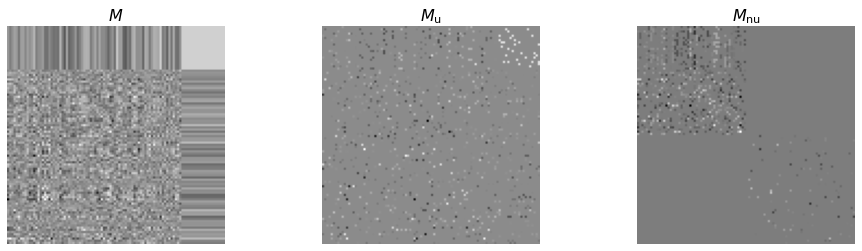

In [9]:
# visualize the results
plot_titles = ['$M$', '$M_\mathrm{u}$', '$M_\mathrm{nu}$']
plt.figure(figsize=(16,4))
for ctr, mat, ptitle in zip(range(3), [M, M_u, M_nu], plot_titles):
    plt.subplot(1,3,ctr+1)
    plt.imshow(mat, cmap='gray')
    plt.title(ptitle,size=16)
    plt.axis('off');

Because of the particularly non-uniform sampling pattern, we cannot observe the behaviour in the upper right hand corner of $M$ — in general this kind of non-uniformity can be detrimental to recovery. However, it is not always practical or realistic to assume a uniform sampling of observations, so we shall look at one way of tackling non-uniform sampling patterns below. In the meantime, 
<div class='alert alert-block alert-info'>
We will make the added assumption that the entries belonging to $\Omega$ were observed **uniformly at random**.
</div>

By making this assumption, we gain our second small advantage. Namely, let $M \in \mathbb{R}^{n\times n}$ be a square matrix of rank $r \ll n$ and let $\Omega \subseteq [m] \times [n]$ be a set of indices such that $(i,j) \in \Omega$ uniformly at random with probability $p \in (0,1)$. Then the matrix
$$
\frac{1}{p} M_\Omega
$$
is an **unbiased estimator** for $M$. Namely, 
$$
\mathbb{E} \big[ \frac{1}{p} M_\Omega \big] = \frac{p}{p} M + \frac{1-p}{p} \mathbf{0} = M
$$

### "Spiky matrices"

A problem that could arise — particularly, as a result of the process determining which entries we get to observe — is if our matrix $M$ is **too spiky**. Probably the best way to illustrate spikiness is with an example. 

In [10]:
W = np.zeros((m,1))
H = np.zeros((n,1))
W[np.random.randint(n, size=5), 0] = 10*np.random.rand(5)
H[np.random.randint(n, size=5), 0] = 10*np.random.rand(5)
M_spiky = W @ H.T

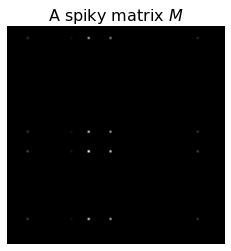

In [11]:
plt.figure(figsize=(4,4))
plt.imshow(M_spiky, cmap='gray')
plt.title('A spiky matrix $M$', size=16)
plt.axis('off');

If $M$ is too spiky, then it is likely that — regardless of the type of random sampling we'll use — the entries of $M$ that we observe will "miss" the "content" of $M$ and give us a false idea of what $M$ looks like. In other words, it is likely to be the case that the content of $M$ we most want to observe in a "spiky" matrix is **where the spikes are**. However, because these spikes are sparse, it is also likely to be the case that we will fail to observe them when we sample entries of $M$!

In other words, we will need $M$ to be **incoherent** in order for a random sampling scheme to work well [most of the time]. This means that the resulting entries of $M$ are a "well-mixed" combination of the entries of $W$ and $H$. To make this precise, let $X \in \mathbb{R}^{m\times n}$ be a matrix such that the columns, $X_j \in \mathbb{R}^m$, of $X$ are normalized: $X_j^* X_j = 1$. The **coherence of the matrix X** is defined by
$$
\mu(X) := \max_{1 \leq j \neq k \leq n} |\langle X_j, X_k \rangle|
$$


<div class='alert alert-info alert-block'>

**Coherence facts**  

1. Characterizes the dependence between columns of $X$  
2. If $X$ is Unitary, then $\mu(X) = 0$  
3. If $n > m$ (like in Compressed Sensing), then $\mu(X) > 0$. Specifically:  
$
\qquad\mu(X) \geq \sqrt{\frac{n - m}{m (n - 1)}}
$  
4. **We want $\mu(X)$ to be small** [so that it is "more like a unitary matrix"]

</div>

## A convex program for incoherent low-rank matrix completion

### Set-up

Supposing we were handed observations $M_\Omega$ and knowledge about the rank $r$ of our matrix, $M$, the problem of recovering $M$ can be phrased suitably in the language of convex optimization:
$$
M_{\#} := \underset{X_\Omega = M_\Omega}{\arg\min}\,\, \mathrm{rank}(X)
$$
*i.e.,* return the matrix of smallest rank that matches $M$ on the observation set $\Omega$. Mild assumptions on the size of $p$ guarantee recovery, $M_{\#} = M$ with high probability. 

Unfortunately, not only is the above problem not convex, but it's NP-hard to find the minimizer! Instead, we can pose the *convex relaxation* of the above problem using a surrogate objective function. This yields the new minimization problem
$$
M^* := \underset{X_\Omega = M_\Omega}{\arg\min}\,\, \|X\|_*
$$
where $\| \cdot \|_*$ denotes the nuclear norm, equal to the sum of the singular values of its argument. For example, using the SVD of $M$, where $\Sigma = \mathrm{diag}((\sigma_i)_{i=1}^r)$, we have
$$
\|M\|_* = \sum_{i=1}^n \sigma_{i}
$$

### Recovery guarantees

As the nuclear norm is a norm, it is convex and hence the *convex relaxation* yields a convex optimization problem. Again, under mild assumptions on $p$, one obtains with high probability the recovery of the original matrix, $M^* = M$. In particular, $|\Omega| \sim \mathcal{O}(r \max\{m,n\} \mathrm{polylog}(\max\{m, n\}))$ uniform-at-random observations of an incoherent matrix are sufficient to guarantee recovery of $M$ with exceedingly high probability. Given that $r \ll \min\{m,n\}$, this is typically a significant reduction in the number of measurements needed if $M$ were of full rank. 

### Noisy recovery

Until this point we have only concerned ourselves with recovery of the matrix $M$; however, problems like subsurface reconstruction are *never* noise-free. We note briefly that there exist analogues of MC algorithms for noisy data, and that there exist convex programs for matrix completion that are robust to noise. For example, the noise-amenable analogue to nuclear norm minimization is as follows. For a noisy matrix $A = M + Z$ where $M$ has rank $r$ and [for example] $Z_{ij} \sim \mathcal{N}(0,\eta^2)$, one can approximate $M$ from a noisy observation set $A_\Omega$ by 
$$
M^* := \arg\min \|X\|_* \quad \text{subj. to} \quad \|A - X\|_F \leq \eta
$$
where $\|\cdot \|_F$ is the Frobenius norm for matrices, defined by
$$
\|A\|_F^2 = \sum_{i,j} |A_{ij}|^2.
$$

# Algorithms for matrix completion

## Introduction

One could argue that there are four main types of algorithms for matrix completion.

1. Nuclear norm minimization
2. Alternating direction method
3. Debiasing low-rank projection
4. Max-norm minimization

Each type holds particular advantages over the other types: some have better developed theory, while others have better applicability or efficacy in practice, while still others are have greater ease of implementation.

### Notation

We define the additional notation $P_\Omega$ to denote the sampling/projection operator,
$$
P_\Omega(M) = M_\Omega
$$
Lastly, we note that equality constraints could be replaced by normed-difference constraints, of the type $\|P_\Omega(X - M)\|_F \leq \eta$, as discussed above.

## Nuclear norm minimization

### An alternative format

We have already seen nuclear norm minimization above. One important point of note is that the nuclear norm minimization problem is equivalent to
$$
(U^*, V^*) := \underset{U,V \in \mathbb{R}^{n\times r}}{\arg\min} \,\, \| U\|_F \|V\|_F \quad \text{subj. to} \quad \|P_\Omega(UV^* - M)\|_F \leq \eta
$$
when the minimization is performed **simultaneously** over $(U,V)$. Unfortunately, this problem set-up is no longer convex. Nevertheless, efficient iterative algorithms exist for approximating the solution to this problem. In particular, fixing an initial $U^0$, iterate
$$
\begin{align*}
V^j &:= \arg\min \|U^j\|_F \|V\|_F \quad \text{subj. to} \quad \|P_\Omega (U^j V^* - M) \|_F \leq \eta\\
U^{j+1} &:= \arg\min \|U\|_F \|V^j\|_F \quad \text{subj. to} \quad \|P_\Omega (U {V^j}^* - M) \|_F \leq \eta
\end{align*}
$$
Algorithms that take this iterative approach to approximate solutions have been coined, creatively, alternating-direction methods. It has been shown that the approximation $\tilde M$ of this particular ADM typically achieves good results, in the sense that 
$$
\mathrm{rmse}(\tilde M, M)
$$ 
is "small". The advantage that this method has over vanilla nuclear norm minimization is the Frobenius norms now implicitly constrain the rank of $U$ and $V$, meaning that only the noise level $\eta$ need be controlled. This is important for applications where the rank is not known (the rank is rarely known in advance). We will discuss the problem of unknown rank more, below.

## Alternating-direction method (ADM)

The first example of an alternating-direction method is actually in the previous section! However, when people think of ADMs for MC, they may typically think of the following problem. 

### Frobenius norm minimization

A simple idea of recovering a low-rank matrix from a set of observations is to minimize the distance between the observed entries, over the set of all low-rank matrices. 
$$
(U,V) := \underset{U,V \in \mathbb{R}^{n\times r}}{\arg\min} \|P_\Omega(UV^* - M)\|_F
$$
Here, the rank constraint is again provided explicitly; and again, this program is non-convex. Empirical results suggest that the iterative approximate algorithm that *is* convex still achieves good results (in the sense of relative mean-squared error). 

### Exercises: write an algorithm

1. Write an algorithm to solve (or approximately solve) this optimization program.
2. *Modify the algorithm to include $\ell^2$ regularization on the entries of $U$ and $V$. How does this effect the performance of the algorithm?
3. Write an algorithm to solve the other form of nuclear norm minimization described above.

<div class='alert alert-block alert-info'>
It is important to make a reasonable initial choice for $U^0$; if $U^0$, for example, lies in the space orthogonal to that spanned by the true $U$, then the algorithm implementing the ADM **may never even converge!** For your implementation, let $U^0$ be the top $r$ left singular vectors of $\frac{1}{p}P_\Omega(M)$, where $p$ is well-approximated by the quotient of the size of the observations set and the total number of entries of the matrix:  
$$ p \approx \displaystyle\frac{\# M_\Omega}{mn}$$
</div>

## Debiasing low-rank projection method

### Overview

The debiasing low-rank projection method is an empirically verified way of dealing with non-uniformly sampled data. It relies on a tool that is a generalization of the **spectral gap** for a matrix, given by $\sigma_1 / \sigma_2$. There is a result from graph theory showing that the spectral gap determines the efficacy of the matrix completion on a given matrix. 

This is a *new* algorithm, by Foucart, Needell, Plan & Wooters. (So I cannot yet provide the reference). 

### Algorithm

Let $Y \in \mathbb{R}^{n\times n}$ be a fixed and unknown matrix, from which we observe the subset of entries $Y_\Omega$ for $\Omega$ a subset of $[n]\times[n]$. Note that $\Omega$ is no longer assumed to be random — it can be deterministic!

1. Define a low-rank approximation to the masked matrix $Y_\Omega$: 
$$
\hat M_0 := \underset{\mathrm{rank}(X) \leq r}{\arg\min} \|X - Y_\Omega\|_F
$$
2. Denote the sampling mask for $\Omega$ by $\mathbf{1}_\Omega$ and let $W$ be the best rank-1 approximation to $\mathbf{1}_\Omega$. We will call $W$ the debiasing matrix:
$$
W := \underset{\mathrm{rank}(W) \leq 1}{\arg\min} \|W - \mathbf{1}_\Omega\|_F
$$
3. Now define the debiased matrix using $W$, where $X^{(j)}$ corresponds to element-wise exponentiation by $j$ of the matrix $X$; and where $\circ$ is the Hadamard (element-wise) product. 
$$
\hat M_{\mathrm{debias}} := W^{(-1)} \circ \hat M_0
$$

### Results

Note that $\#\mathrm{measurements} \geq C (m+n)r \max(r, \log(m+n))$ are required to achieve good recovery. Precises error bounds on the approximation are given in the manuscript, but it would require too much background information to describe here. 

### Exercise: Code the algorithm

<div class='alert alert-block alert-info'>
1. If you feel comfortable using Python, try coding this algorithm! Otherwise, continue following along and come back to coding this algorithm after you have seen implementations of some others, below.  
2. **Challenge:** If you choose to implement this algorithm, try it out on the music listening history data set and compare it against one of the other methods described here. There are currently no empirical results directly comparing this algorithm with others!
</div>

## Max-norm minimization

One can also relax the rank constraint in a second way. Namely, via the so-called **max-norm**:
$$
\|X \|_\text{max} := \inf_{U,V} \big\{\|U\|_{2, \infty} \|V\|_{2, \infty} : X = U V^* \big\}
$$
where, for $A \in \mathbb{R}^{m\times n}$
$$
\|A\|_{2, \infty} := \max_{j\in[m]} \big( \sum_{k=1}^n A_{jk}^2 \big)^{1/2}
$$

<div class='alert alert-block alert-info'>
**Note:** there is no satisfying theoretical explanation for why $\max$-norm minimization works well!
</div>

### Exercise: write an algorithm

1. Write an algorithm that solves (or approximately solves) the max-norm minimization problem. Would you expect this to work better or worse than the methods described above (or does it depend on some properties of the data?)
2. Is your method more or less efficient than the other methods described above (*Hint:* how many flops per iteration does your algorithm require? Is it parallelizable?)

## On selecting the rank

### Issues

If the rank is too small, then clearly the recovered matrix $M^*$ cannot be as "expressive" as the matrix $M$ — the space it spans is of smaller dimension than that of $M$! This problem will occur regardless of the optimization algorithm we choose. What happens, then, if the rank is too big? In the ideal case, nothing happens: the lowest rank solution is the optimal one and so nothing changes. In reality, this is not the case, particularly with those methods that require an explicit rank to be passed as a parameter. These methods can show disastrous instability if the rank is chosen incorrectly. Moreover, if the rank is too large, then it increases computation time — per iteration cost typically looks like $Crn\log n$, hence doubling $r$ doubles the time until convergence. 

### Exercises: making progress on the issues above

1. Is there a way to efficiently approximate the rank of a matrix $P_\Omega(M)$? Can you use this as a way to efficiently find a rank parameter $r$ that gives good recovery on an optimization program that requires a rank parameter $r$? 
2. For one of the algorithms described above, can you modify the algorithm to better control for instability for incorrectly chosen rank parameters? (**Hint:** is there a regularization that would help?)

# Coding matrix completion problems

## Nuclear norm minimization for matrix completion

### Description

In this example, we showcase nuclear norm minimization using the Python package [`cvxpy`](http://www.cvxpy.org/en/latest/index.html). The `cvxpy` package mostly sits on top of [`cvxopt`](http://cvxopt.org/userguide/index.html), which to my knowledge is a port of [`CVX`](http://cvxr.com/cvx/) by Stephen Boyd and Michael Grant. Note that for this example, the default solver will not work, and instead we will use `SCS` &mdash; a splitting conic solver (more details available [here](https://arxiv.org/abs/1312.3039)). 

### Problem set-up

Define the matrix $M$ and the mask $\Omega$.

In [12]:
r = 5
m = 100
n = 100
p = .5
U, V, M_Omega, Omega_idx, Omega_mask = matrixCompletionSetup(r, m, n, p)

There has been a re-write of this function. Please check documentation or source for more information. (cf. sparseMatComSetup for a sparse version of this function.)


Now phrase the optimizaton problem using `cvxpy`.

In [13]:
X = Variable((m, n))
obj = Minimize(cvxnorm(X, 'nuc') )
constraints = [X[Omega_idx] == M_Omega]
prob = Problem(obj, constraints)

In [14]:
prob.solve(solver=SCS, verbose=False)

2866.662786641303

RMSE = 1.276435843251392e-05


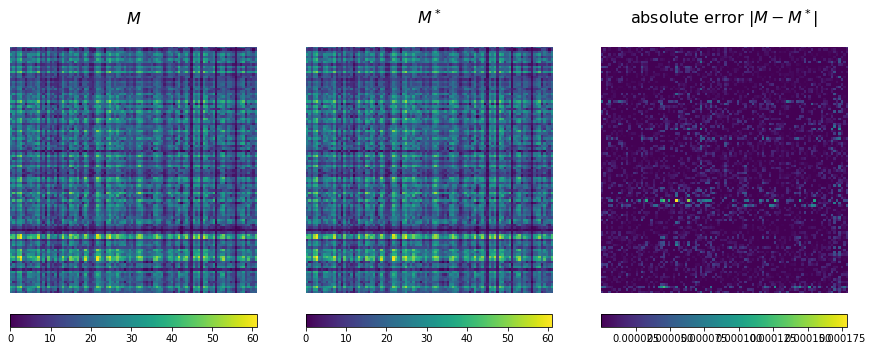

In [15]:
M = U @ V.T
plot_comparison(M, X.value)

## Implement an alternating-direction method

### Exercises: Implement the ADM algorithm for Frobenius norm minimization

1. Use `cvxpy` to implement the ADM for Frobenius norm minimization with rank $r$. 
2. Bonus: re-formulate the ADM using the matrix re-shaping above, and write a new algorithm that approximately solves the Frobenius norm minimization using least squares. (see Aaron for helpful code for this)

In [16]:
# Define a small problem
m = n = 50
r = 3
p = .5
U, V, M_Omega, Omega_idx, Omega_mask = matrixCompletionSetup(r, m, n, p)
M = U @ V.T

There has been a re-write of this function. Please check documentation or source for more information. (cf. sparseMatComSetup for a sparse version of this function.)


`altMinSense` implementation using [`cvxpy`](http://www.cvxpy.org/) and [Jain & Netrapalli, 2012](https://arxiv.org/pdf/1212.0467.pdf).

In [17]:
U_cvx, V_cvx = altMinSense(M_Omega=M_Omega, Omega_mask=Omega_mask, r=2, method='cvx')


Optimality conditions satisfied.
Objective value =    55


RMSE = 1.8340109449290496


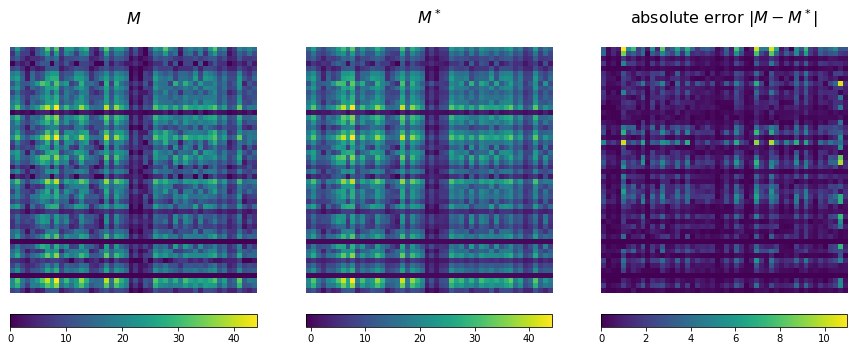

In [18]:
plot_comparison(M, U_cvx @ V_cvx.T)

<div class='alert alert-info alert-block'>
We need $\mathcal{O}(rn \log n)$ samples of the matrix in order to guarantee good recovery; when the matrix is this small, that's very hard to do (because the constant hidden by the $\mathcal{O}$ could be large). If we want a better demonstration of the recovery method, then we need to start with bigger data. 
</div>

In [19]:
r = 5
m = 100
n = 100
p = .5

U, V, M_Omega, Omega_idx, Omega_mask = matrixCompletionSetup(r, m, n, p)
M = U @ V.T

There has been a re-write of this function. Please check documentation or source for more information. (cf. sparseMatComSetup for a sparse version of this function.)


In [20]:
U_approx, V_approx = altMinSense(M_Omega=M_Omega, Omega_mask=Omega_mask, r=r)
M_opt = U_approx @ V_approx.T


Optimality conditions satisfied.
Objective value = 1.26e-05


RMSE = 2.5762643257094546e-07


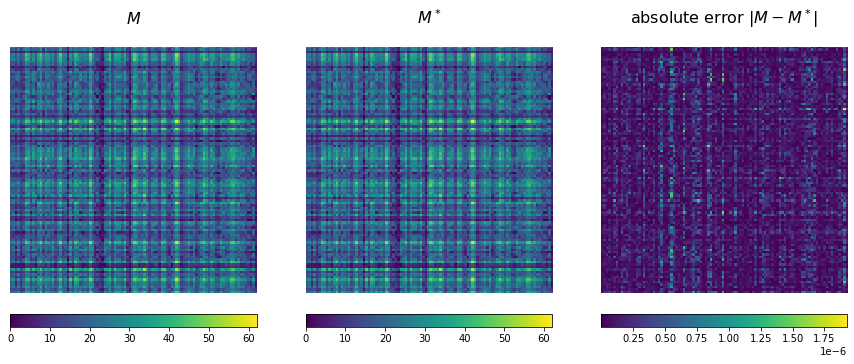

In [21]:
plot_comparison(M, M_opt)

## Debiasing low-rank projection implementation

### Approximate observation mask

**From graph theory:** we can view the observation mask as an adjacency matrix of a $d$-regular graph; it is guaranteed that the leading left singular vector of this graph has positive entries. 

**From linear algebra:** the leading singular vectors of a matrix yield the best rank-1 approximation to that matrix. 

**From MC and graph theory:** the best rank-1 approximation to the observation mask gives a generalization of the spectral gap that guarantees recovery of a matrix. 

The computation of the leading singular vectors will be fastest if we have a sparse observation mask. We have already imported `svds`, the sparse svd solver from `scipy.sparse.linalg`. 

#### Method 1: `svds`

In [22]:
sparseMask = csr_matrix(Omega_mask.astype(np.int)).asfptype()
u, s, vt = svds(sparseMask, k=1)
W = (s*u) @ vt

<ipython-input-22-242d214c02f5>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sparseMask = csr_matrix(Omega_mask.astype(np.int)).asfptype()


RMSE = 0.49493222000251047


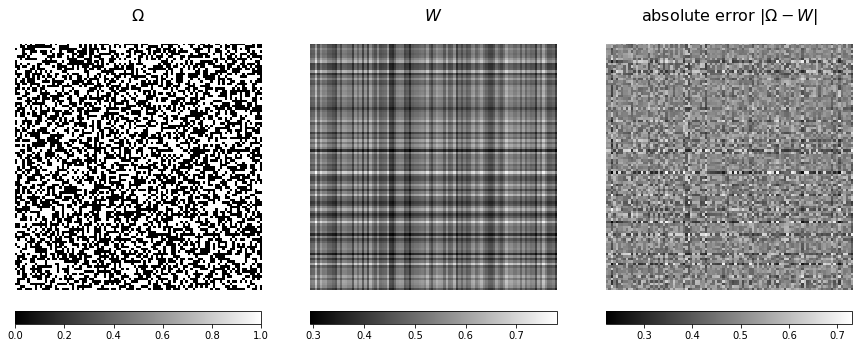

In [23]:
plot_comparison(Omega_mask, W, cmap='gray',
                plot_titles=['$\Omega$', '$W$'], 
                error_title='absolute error $|\Omega - W|$')

#### Method 2: `altMinSense`

In [24]:
W_l, W_r = altMinSense(vec(Omega_mask), np.ones(Omega_mask.shape), 1)

Iteration 0: Objective = 49.493222000251194
Optimality conditions satisfied.
Objective value =  49.5


In [25]:
W2 = W_l @ W_r.T

RMSE = 0.49493222000251197


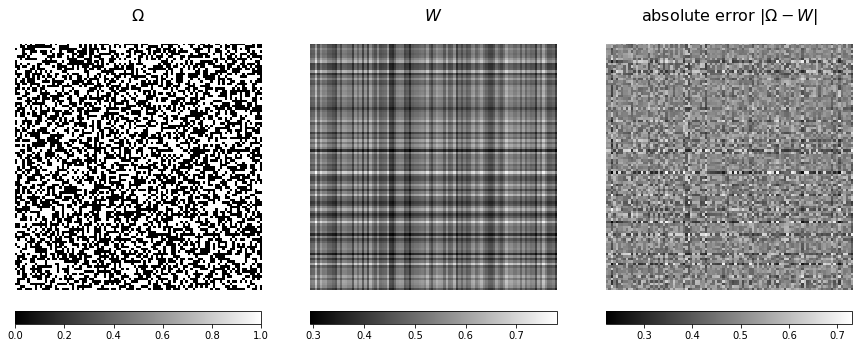

In [26]:
plot_comparison(Omega_mask, W2, cmap='gray',
                plot_titles=['$\Omega$', '$W$'], 
                error_title='absolute error $|\Omega - W|$')

#### Comparison

RMSE = 3.776191799775153e-08


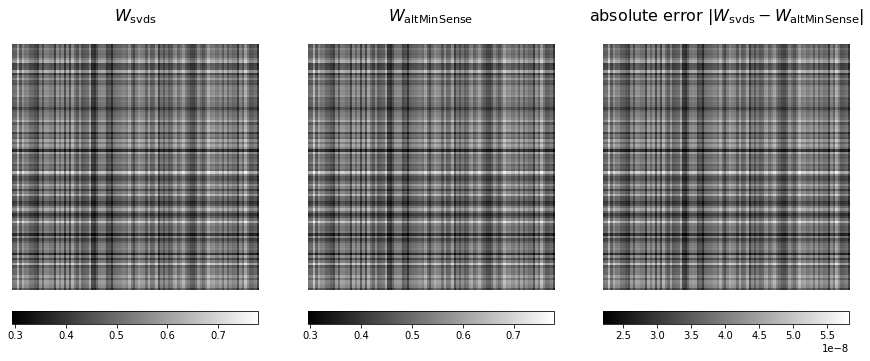

In [27]:
plot_comparison(W, W2, cmap='gray',
                plot_titles=['$W_{\mathrm{svds}}$', '$W_{\mathrm{altMinSense}}$'], 
                error_title='absolute error $|W_{\mathrm{svds}} - W_{\mathrm{altMinSense}}|$')

This achieves the same thing, but it actually takes longer! Also, there's a trick as to why it recovers the same thing (since the same thing would not work in this way for what we're about to do next...)

### Compute $\hat M_0$

In [28]:
M_masked = csr_matrix(M*Omega_mask).asfptype()

In [29]:
u_masked, s_masked, vt_masked = svds(M_masked, k=r)

In [30]:
M0 = (u_masked * s_masked) @ vt_masked

RMSE = 9.99439570762223


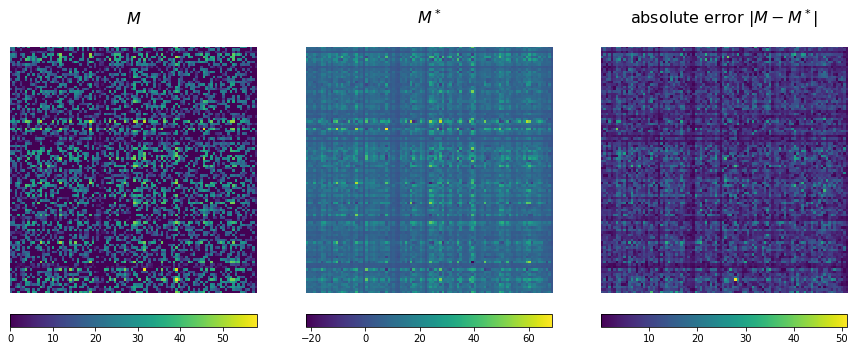

In [31]:
plot_comparison(M*Omega_mask, M0)

### Take the Hadamard product

In [32]:
M_debias = M0 * W**(-1)

### Observe the results

RMSE = 10.979942190676862


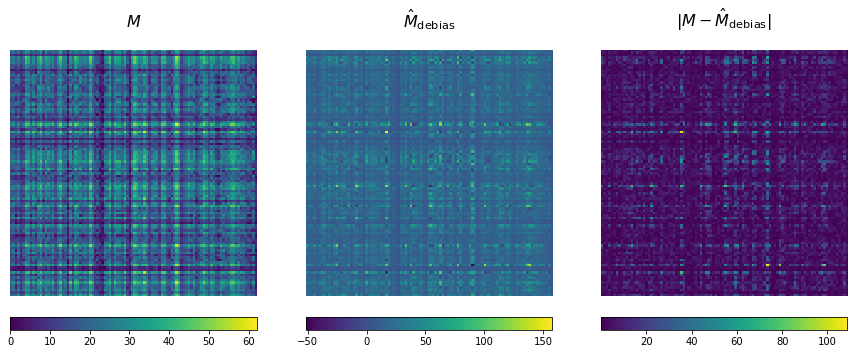

In [33]:
plot_comparison(M, M_debias, cmap='viridis',
                plot_titles=['$M$', '$\hat M_\mathrm{debias}$'], 
                error_title='$|M - \hat M_\mathrm{debias}|$')

This isn't working too well! Not sure why...

# On the use of sparse matrices

**Disclosure:** I didn't sparsify everything as much as I could have. But one should do this when one has many, many zero-valued entries in high-dimensional matrices. A justification for this follows. 

In [34]:
def sizeOfCsr(A):
    """
    sizeOfCsr(A) returns size (in bytes) of
        the compressed sparse row matrix A.
    """
    return A.data.nbytes + A.indptr.nbytes + A.indices.nbytes

In [35]:
def compressionFactor(A, A_csr):
    return sizeOfCsr(A_csr) / A.__sizeof__()

In [36]:
from scipy.sparse import csr_matrix
m = 1000
n = 10000
delta = .1 # sparsity proportion
s = np.int(delta * n) # sparsity level
A_nnz = np.random.randn(s)
A_ij = (np.random.randint(m, size=s), np.random.randint(n, size=s))
A = np.zeros((m,n))
A[A_ij] = A_nnz
A_sparse = csr_matrix(A)
print('Compression factor = {} %'.format(np.round(compressionFactor(A, A_sparse)*100, 5)))

Compression factor = 0.02 %


<ipython-input-36-4beaae02ea95>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  s = np.int(delta * n) # sparsity level


# The realm of parameter guessing

What happens when we have to guess the rank? Things no longer work so well!

## What happens when rank is chosen incorrectly?

In practice we **"never"** know the rank. Sometimes, we're happy to correctly under-estimate the rank (we think it's lower than it really is), because perhaps we want a lower-dimensional approximation of what's going on. However, there are other times where it is important to accurately determine the rank, and in these cases we do not want to over-estimate! Why?
* Choosing the rank too large means that our algorithms (which run in $\mathcal{O}(r \log n)$) take longer to solve
* What if choosing the rank too large causes 
   * overfitting?
   * instability?
   * huge errors?

In [37]:
U_approx, V_approx = altMinSense(M_Omega, Omega_mask=Omega_mask, r=15)


Optimality conditions satisfied.
Objective value = 0.00284


RMSE = 0.16326554268154558


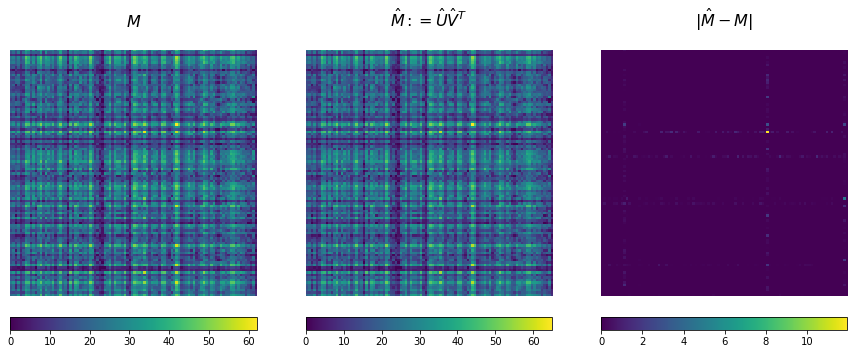

In [38]:
plot_comparison(M, U_approx @ V_approx.T, 
                plot_titles=['$M$', '$\\hat M := \\hat U \\hat V^T$'], 
                error_title='$|\hat M - M|$')

## What happens in the presence of noise?

How does this modify the algorithm? Can we gain any advantages? 

# Out-of-the-box packages

Below are some packages for out-of-the-box implementations of algorithms related to matrix completion (*e.g.* nuclear norm minimization, matrix least squares, *etc.*).

* `scipy` : Iterative SVD; Sparse Methods; Least Squares Solvers
* `sklearn` : Nonnegative Matrix Factorization; Truncated SVD
* `pyspark.mllib` : Distributed and parallel implementation; k-Nearest Neighbours
* `fancyimpute` : Nuclear norm minimization; Bayesian ridge regression; SoftImpute; Similarity-weighted averages; *etc.*
* `keras` and `tensorflow` : Powerful ML methods for learning low-dimensional sub-spaces

An other example

In [39]:
import numpy as np

# Generate a random 10x20 matrix of rank 5
m, n, r = (10, 20, 5)
A = np.random.normal(size=(m, r))
B = np.random.normal(size=(r, n))
X = A @ B

# Compute the SVD
U, S, V = np.linalg.svd(X, full_matrices=False)

# Confirm U S V = X
np.allclose(U @ np.diag(S) @ V, X)

True

Text(0.5, 1.0, 'Plot of singular values')

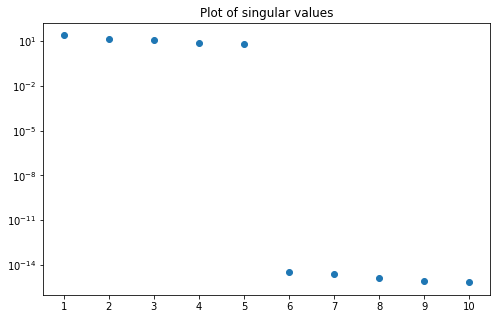

In [40]:
import matplotlib.pyplot as plt

DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(S) + 1), S, "o")
plt.xticks(np.arange(1, len(S) + 1))
plt.yscale("log")
plt.title("Plot of singular values")

In [41]:
A = U[:, :r] * S[:r]
B = V[:r, :]
print(A.shape, B.shape)

np.allclose(A @ B, X)

(10, 5) (5, 20)


True

The matrix is approximately of rank: 4


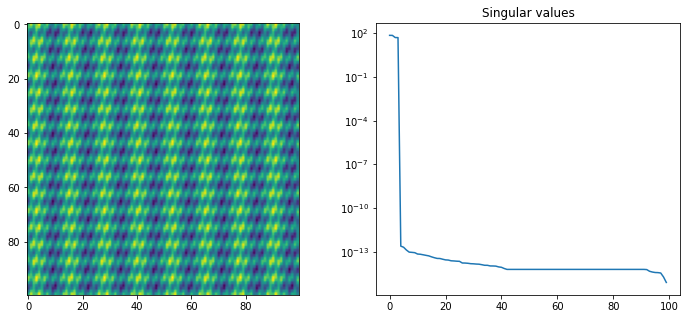

In [42]:
# Make a grid of 100 x 100 values between [0,1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)

# A smooth trigonometric function
def f(x, y):
    return np.sin(200 * x + 75 * y) + np.sin(50 * x) + np.cos(100 * y)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
X = f(x, y)
plt.imshow(X)

plt.subplot(1, 2, 2)
U, S, V = np.linalg.svd(X)
plt.plot(S)
plt.yscale("log")
plt.title("Singular values")
print(f"The matrix is approximately of rank: {np.sum(S>1e-12)}")

Text(0, 0.5, 'Mean squared error')

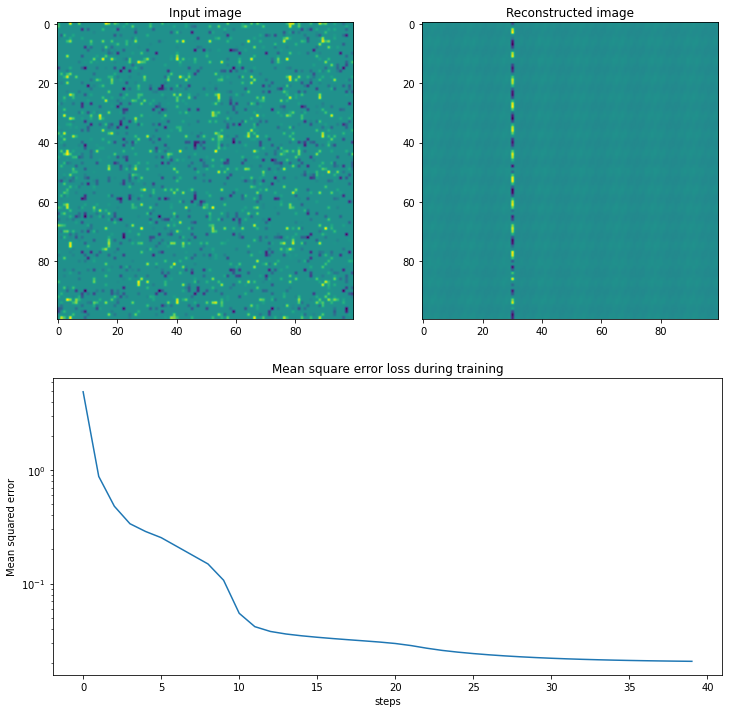

In [43]:
N = 2000
n = 100
r = 4

# Sample N=2000 random indices
Omega = np.random.choice(n * n, size=N, replace=False)
Omega = np.unravel_index(Omega, X.shape)
y = X[Omega]

# Use random initialization for matrices A,B
A = np.random.normal(size=(n, r))
B = np.random.normal(size=(r, n))


def linsolve_regular(A, b, lam=1e-4):
    """Solve linear problem A@x = b with Tikhonov regularization / ridge
    regression"""
    return np.linalg.solve(A.T @ A + lam * np.eye(A.shape[1]), A.T @ b)


losses = []
for i in range(40):
    loss = np.mean(((A @ B)[Omega] - y) ** 2)
    losses.append(loss)

    # Update B
    for j in range(n):
        B[:, j] = linsolve_regular(A[Omega[0][Omega[1] == j]], y[Omega[1] == j])

    # Update A
    for i in range(n):
        A[i, :] = linsolve_regular(
            B[:, Omega[1][Omega[0] == i]].T, y[Omega[0] == i]
        )

# Plot the input image
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Input image")
S = np.zeros((n, n))
S[Omega] = y
plt.imshow(S)

# Plot reconstructed image
plt.subplot(2, 2, 2)
plt.title("Reconstructed image")
plt.imshow(A @ B)

# Plot training loss
plt.subplot(2, 1, 2)
plt.title("Mean square error loss during training")
plt.plot(losses)
plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("Mean squared error")

# A last example

Text(0.5, 0.98, 'Low-Rank Approximation of a Matrix')

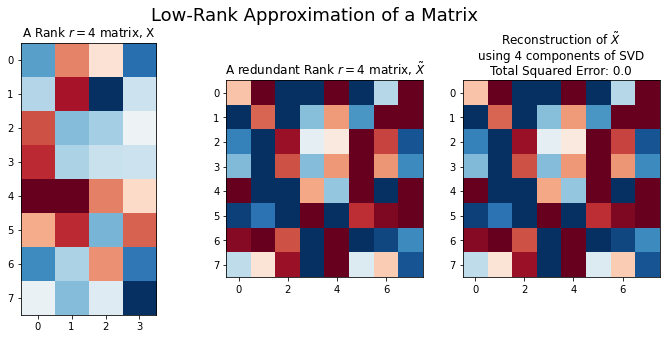

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'RdBu_r'
np.random.seed(123) # Repeatability
MATRIX_RANK = 4

# Create a random matrix, which will have independent columns
# and thus a rank equal to the number of columns
X_orig = np.random.randn(8, MATRIX_RANK)
X_orig_rank = np.linalg.matrix_rank(X_orig)

# Create a new redundant matrix with twice as many columns, but new columns are
# simply a linear scaling of original matrix
X_redundant = np.hstack([-2 * X_orig, 2 * X_orig])

# Permute columns of redundant matrix
X_redundant = X_redundant[:, np.random.permutation(np.arange(X_redundant.shape[1]))]
X_redundant_rank = np.linalg.matrix_rank(X_redundant)

# Run SVD on redundant matrix, we'll use this for LRA
U, S, V = np.linalg.svd(X_redundant)

# Low-rank reconstruction (exact in this case)
X_redundant_reconstructed = U[:, :MATRIX_RANK] * S[:MATRIX_RANK] @ V[:MATRIX_RANK, :]
reconstruction_error = np.sum((X_redundant - X_redundant_reconstructed) ** 2)

# Visualizations
## Original matrix
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
plt.sca(axs[0])
plt.imshow(X_orig)
plt.clim([-2, 2])
plt.title(f"A Rank $r=${X_orig_rank} matrix, X")

## Redundant matrix
plt.sca(axs[1])
plt.imshow(X_redundant)
plt.clim([-2, 2])
plt.title(f"A redundant Rank $r=${X_redundant_rank} matrix, $\\tilde X$")

## Low-rank approximation (exact reconstruction)
plt.sca(axs[2])
plt.imshow(X_redundant_reconstructed)
plt.clim([-2, 2])
plt.title(f"Reconstruction of $\\tilde X$\nusing {MATRIX_RANK} components of SVD\nTotal Squared Error: {reconstruction_error:1.1f}")
plt.suptitle("Low-Rank Approximation of a Matrix", fontsize=18)

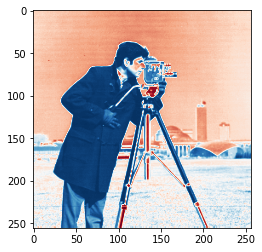

In [45]:
import urllib.request
import PIL

# read the image file in a numpy array
img = np.array(PIL.Image.open(urllib.request.urlopen("http://users.polytech.unice.fr/~strombon/SSI/s11.Image/ScilabScripts/cameraman.png")))
np.size(img)
plt.imshow(img)

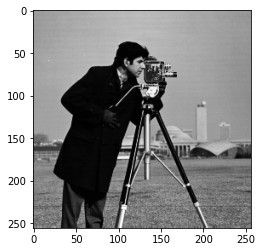

In [46]:
from skimage import io
img = io.imread("http://users.polytech.unice.fr/~strombon/SSI/s11.Image/ScilabScripts/cameraman.png")
plt.imshow(img, cmap='gray')
plt.show()

## On utilise h2o

In [47]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-72).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [48]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.9/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0095tudd
  JVM stdout: /tmp/tmp0095tudd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0095tudd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_osdyfx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%


Text(0.5, 1.0, 'Cumulative % of Information About $X$\nCarried by Singular Vectors')

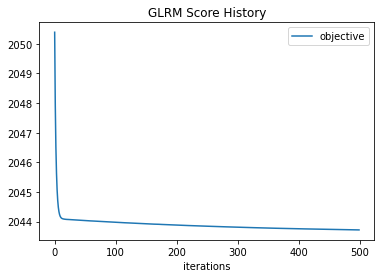

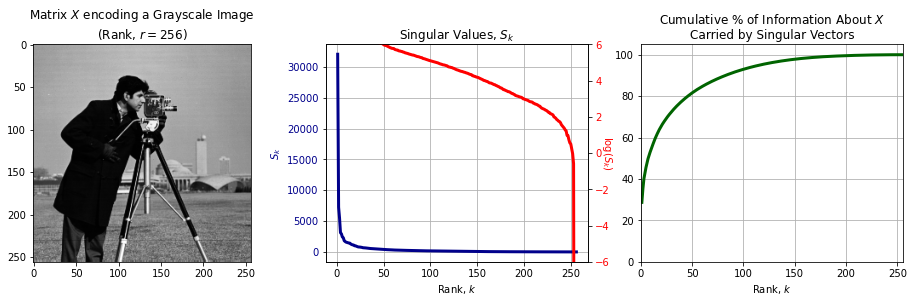

In [50]:
from h2o.h2o import H2OFrame
from h2o.estimators import H2OGeneralizedLowRankEstimator

X= img 

# h2o
train = H2OFrame(python_obj=X)
# Build and train the model:
glrm_model = H2OGeneralizedLowRankEstimator(k=50,
                                            loss="quadratic",
                                            gamma_x=0.5,
                                            gamma_y=0.5,
                                            max_iterations=500,
                                            recover_svd=True,
                                            init="SVD",
                                            transform="standardize")
glrm_model.train(training_frame=train)
glrm_model.model_performance()
glrm_model.score_history().plot(x='iterations', y='objective', title='GLRM Score History')


#####
# Calculate the rank of the data matrix, X
img_rank = np.linalg.matrix_rank(X, 0.)

# Run SVD on Image
U, S, V = np.linalg.svd(X)

# Calculate the cumulative variance explained by each singular value
total_S = S.sum()
n_components = len(S)
component_idx = range(1,  n_components + 1)
info_retained = 100 * np.cumsum(S) / total_S

# Visualizations
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

## Raw Image, X
plt.sca(axs[0])
plt.imshow(X, cmap='gray')
plt.title(f"Matrix $X$ encoding a Grayscale Image\n(Rank, $r=${img_rank})")

## Singular values as function of rank
plt.sca(axs[1])

### Raw singular values
plt.plot(component_idx, S, label='Singular Values of $$X$$', color='darkblue', linewidth=3)
plt.grid()
plt.xlabel("Rank, $k$")
plt.ylabel('$S_k$', color='darkblue')
plt.tick_params(axis='y', labelcolor='darkblue')
plt.title('Singular Values, $S_k$')

### log(singular values)
twax = plt.gca().twinx()  # twin axes that shares the same x-axis
twax.plot(component_idx, np.log(S), color='red', linewidth=3)
plt.ylabel('$\log(S_k)$\n', color='red', rotation=270)
plt.tick_params(axis='y', labelcolor='red')
plt.ylim([-6, 6])

## Information retained as function of rank
plt.sca(axs[2])
plt.plot(component_idx, info_retained, color='darkgreen', linewidth=3)
plt.xlim(0, n_components)
plt.ylim([0, 105])
plt.xlabel("Rank, $k$")
plt.grid()
plt.title('Cumulative % of Information About $X$\nCarried by Singular Vectors')